<a href="https://colab.research.google.com/github/Rongxuan-Zhou/CS6120_project/blob/main/notebooks/1_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Environment Setup
!pip install -q pandas matplotlib seaborn datasets psutil requests
from google.colab import drive
drive.mount('/content/drive')

# Copy src directory to Colab
import os
import shutil
PROJECT_PATH = "/content/drive/MyDrive/CS6120_project"
SRC_PATH = os.path.join(PROJECT_PATH, "src")
if os.path.exists(SRC_PATH):
    shutil.copytree(SRC_PATH, "/content/src")
    import sys
    sys.path.append("/content")
    print("Successfully copied src directory to Colab")
else:
    print(f"Warning: Could not find src directory at {SRC_PATH}")

# Memory monitoring
import psutil
print(f"Available memory: {psutil.virtual_memory().available/1024**3:.2f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cu

In [2]:
# 2. MSMARCO Data Loading
try:
    from src.data_preparation import DataPreprocessor
except ImportError:
    from content.src.data_preparation import DataPreprocessor
import pandas as pd
from datasets import load_dataset

# Initialize preprocessor
preprocessor = DataPreprocessor()

# Load MSMARCO dataset
try:
    print("Attempting to load MSMARCO dataset...")

    # Try different dataset names/versions
    dataset_names = ["ms_marco", "microsoft/ms_marco", "msmarco"]
    versions = ["v1.1", "v2.1", "v2.0", None]

    for name in dataset_names:
        for version in versions:
            try:
                config = f" (version: {version})" if version else ""
                print(f"Trying {name}{config}...")

                if version:
                    msmarco = load_dataset(name, version)
                else:
                    msmarco = load_dataset(name)

                if len(msmarco['train']) > 0:
                    print(f"Successfully loaded {name}{config}")

                    # Version-aware data processing
                    docs = []
                    for doc in msmarco['train'].select(range(10000)):
                        if version == "v1.1":
                            if 'passages' in doc and 'passage_text' in doc['passages'] and len(doc['passages']['passage_text']) > 0:
                                docs.append({
                                    'text': doc['passages']['passage_text'][0],
                                    'length': len(doc['passages']['passage_text'][0])
                                })
                        elif version == "v2.1":
                            if 'passage' in doc and len(doc['passage']) > 0:
                                docs.append({
                                    'text': doc['passage'],
                                    'length': len(doc['passage'])
                                })

                    msmarco_df = pd.DataFrame(docs)
                    break
            except Exception as e:
                print(f"Failed with {name}{config}: {str(e)[:100]}")
        else:
            continue
        break

    if 'msmarco_df' not in locals():
        raise ValueError("Could not load any version of MSMARCO dataset")

    print(f"MSMARCO statistics:\n{msmarco_df.describe()}")

except Exception as e:
    print(f"Failed to load MSMARCO: {e}")
    # Fallback to local data if available
    try:
        local_path = os.path.join(PROJECT_PATH, "data/msmarco_sample.csv")
        if os.path.exists(local_path):
            print("Attempting to load local data...")
            msmarco_df = pd.read_csv(local_path)
            print("Loaded local MSMARCO sample data")
    except Exception as e:
        print(f"Failed to load local data: {e}")
    finally:
        if 'msmarco_df' not in locals():
            # Create empty dataframe if all else fails
            msmarco_df = pd.DataFrame(columns=['text', 'length'])
            print("Created empty dataframe as fallback")

Attempting to load MSMARCO dataset...
Trying ms_marco (version: v1.1)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

Successfully loaded ms_marco (version: v1.1)
MSMARCO statistics:
             length
count  10000.000000
mean     413.868500
std      147.925227
min       56.000000
25%      288.000000
50%      410.000000
75%      538.000000
max     1167.000000


In [3]:
# 3. Twitter Data Loading with Improved Encoding Handling
import zipfile
from tqdm import tqdm
import requests
import chardet

def detect_file_encoding(file_path):
    """Detect file encoding using chardet"""
    with open(file_path, 'rb') as f:
        rawdata = f.read(10000)  # Read first 10KB for detection
    result = chardet.detect(rawdata)
    return result['encoding']

def read_text_file_with_fallback(file_path):
    """Read text file with multiple encoding fallbacks"""
    # Try to detect encoding first
    try:
        detected_encoding = detect_file_encoding(file_path)
        print(f"Detected encoding: {detected_encoding}")
        if detected_encoding:
            try:
                with open(file_path, 'r', encoding=detected_encoding) as f:
                    return f.read().splitlines()
            except UnicodeDecodeError as e:
                print(f"Failed with detected encoding {detected_encoding}: {e}")
    except Exception as e:
        print(f"Error in encoding detection: {e}")

    # Fallback encodings
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1', 'ascii']

    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.read().splitlines()
        except UnicodeDecodeError as e:
            print(f"Failed with encoding {encoding}: {e}")

    # Last resort: read with errors='ignore'
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            print("Reading with utf-8 and ignoring errors")
            return f.read().splitlines()
    except Exception as e:
        print(f"Failed even with error ignoring: {e}")

    # If all else fails, read as binary and decode manually
    try:
        with open(file_path, 'rb') as f:
            binary_data = f.read()
            # Try to decode with 'replace' option to substitute invalid chars
            text = binary_data.decode('utf-8', errors='replace')
            return text.splitlines()
    except Exception as e:
        print(f"Failed with binary reading: {e}")
        return []  # Return empty list as last resort

try:
    print("Attempting to load Twitter dataset...")

    # Download Twitter data
    twitter_url = "https://archive.org/download/twitter_cikm_2010/twitter_cikm_2010.zip"
    twitter_zip = "/content/twitter.zip"

    if not os.path.exists(twitter_zip):
        print("Downloading Twitter data...")
        response = requests.get(twitter_url, stream=True)
        response.raise_for_status()

        with open(twitter_zip, 'wb') as f:
            for chunk in tqdm(response.iter_content(chunk_size=8192)):
                f.write(chunk)

    # Extract and process tweets
    print("Extracting Twitter data...")
    with zipfile.ZipFile(twitter_zip, 'r') as zip_ref:
        zip_ref.extractall("/content/twitter_data")

    # Find the extracted directory (handle different extraction paths)
    extracted_dir = None
    for root, dirs, files in os.walk("/content/twitter_data"):
        if any(f.endswith('.txt') for f in files):
            extracted_dir = root
            break

    if not extracted_dir:
        raise FileNotFoundError("Could not find extracted Twitter data directory")

    print(f"Found Twitter data in: {extracted_dir}")

    # Process each file in the extracted directory with improved encoding handling
    tweets = []
    for file in os.listdir(extracted_dir):
        if file.endswith(".txt"):
            file_path = os.path.join(extracted_dir, file)
            print(f"Processing file: {file}")
            lines = read_text_file_with_fallback(file_path)
            tweets.extend(lines)
            print(f"Added {len(lines)} tweets from {file}")

    # Clean and create dataframe
    print("Cleaning Twitter data...")
    # Limit to 10k tweets to avoid memory issues
    tweets = tweets[:10000]
    cleaned_tweets = []
    for tweet in tweets:
        if isinstance(tweet, str) and tweet.strip():
            cleaned_tweets.append(preprocessor.clean_text(tweet))

    twitter_df = pd.DataFrame({
        'text': cleaned_tweets,
        'length': [len(tweet) for tweet in cleaned_tweets]
    })

    print(f"Loaded {len(twitter_df)} tweets")
    print(f"Twitter statistics:\n{twitter_df.describe()}")

except Exception as e:
    print(f"Failed to load Twitter data: {e}")
    # Fallback to local data if available
    try:
        local_path = os.path.join(PROJECT_PATH, "data/twitter_sample.csv")
        if os.path.exists(local_path):
            print("Attempting to load local Twitter data...")
            twitter_df = pd.read_csv(local_path)
            print("Loaded local Twitter sample data")
    except Exception as e:
        print(f"Failed to load local Twitter data: {e}")
    finally:
        if 'twitter_df' not in locals():
            # Create empty dataframe if all else fails
            twitter_df = pd.DataFrame(columns=['text', 'length'])
            print("Created empty Twitter dataframe as fallback")

Attempting to load Twitter dataset...


51784it [01:32, 557.80it/s]


Extracting Twitter data...
Found Twitter data in: /content/twitter_data
Processing file: training_set_tweets.txt
Detected encoding: Windows-1252
Failed with detected encoding Windows-1252: 'charmap' codec can't decode byte 0x9d in position 48556: character maps to <undefined>
Added 3845673 tweets from training_set_tweets.txt
Processing file: test_set_tweets.txt
Detected encoding: ascii
Failed with detected encoding ascii: 'ascii' codec can't decode byte 0xc3 in position 78457: ordinal not in range(128)
Added 5156047 tweets from test_set_tweets.txt
Processing file: training_set_users.txt
Detected encoding: ascii
Added 115886 tweets from training_set_users.txt
Processing file: test_set_users.txt
Detected encoding: ascii
Failed with detected encoding ascii: 'ascii' codec can't decode byte 0x9c in position 25870: ordinal not in range(128)
Failed with encoding utf-8: 'utf-8' codec can't decode byte 0x9c in position 25870: invalid start byte
Added 5136 tweets from test_set_users.txt
Cleaning

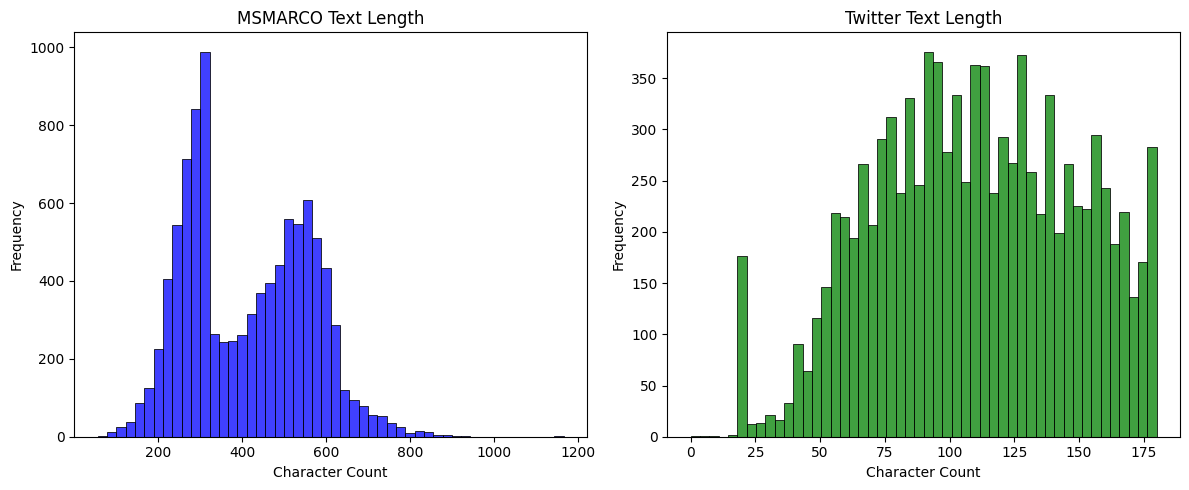

In [4]:
# 4. Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# MSMARCO text length distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(msmarco_df['length'], bins=50, color='blue')
plt.title('MSMARCO Text Length')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

# Twitter text length distribution
plt.subplot(1, 2, 2)
sns.histplot(twitter_df['length'], bins=50, color='green')
plt.title('Twitter Text Length')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

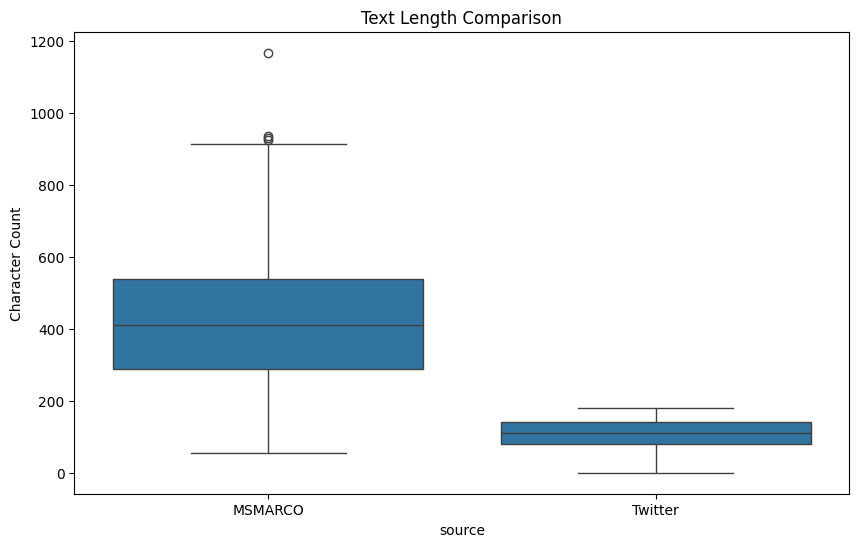


Combined Dataset Statistics by Source:
           count        mean         std   min    25%    50%    75%     max
source                                                                     
MSMARCO  10000.0  413.868500  147.925227  56.0  288.0  410.0  538.0  1167.0
Twitter   9966.0  109.636765   38.535516   0.0   81.0  109.0  140.0   180.0


In [5]:
# 5. Combined Data Analysis
# Add source labels to each dataset
msmarco_df['source'] = 'MSMARCO'
twitter_df['source'] = 'Twitter'

# Combine datasets for comparison
combined_df = pd.concat([msmarco_df, twitter_df])

# Plot combined length distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='source', y='length', data=combined_df)
plt.title('Text Length Comparison')
plt.ylabel('Character Count')
plt.show()

# Summary statistics by source
print("\nCombined Dataset Statistics by Source:")
print(combined_df.groupby('source')['length'].describe())

In [6]:
# 6. Memory Optimization Check
def check_memory_usage(df, name):
    mem_usage = df.memory_usage(deep=True).sum() / 1024**2
    print(f"{name} memory usage: {mem_usage:.2f} MB")
    if mem_usage > 500:  # Warning if exceeds 500MB
        print(f"Warning: High memory usage for {name}, consider optimizing data types")

check_memory_usage(msmarco_df, "MSMARCO")
check_memory_usage(twitter_df, "Twitter")
check_memory_usage(combined_df, "Combined")

MSMARCO memory usage: 6.12 MB
Twitter memory usage: 2.27 MB
Combined memory usage: 8.54 MB


In [7]:
# 7. Save Processed Data
# Save processed datasets for future use
msmarco_df.to_csv('/content/msmarco_processed.csv', index=False)
twitter_df.to_csv('/content/twitter_processed.csv', index=False)
print("Saved processed datasets to CSV files")

# Optional: Copy to Google Drive if needed
save_to_drive = False  # Set to True to save to Google Drive
if save_to_drive:
    drive_data_path = os.path.join(PROJECT_PATH, "data")
    os.makedirs(drive_data_path, exist_ok=True)
    msmarco_df.to_csv(os.path.join(drive_data_path, "msmarco_processed.csv"), index=False)
    twitter_df.to_csv(os.path.join(drive_data_path, "twitter_processed.csv"), index=False)
    print(f"Saved processed datasets to Google Drive at {drive_data_path}")

Saved processed datasets to CSV files
